In [0]:
!pip install PyDrive

In [0]:
import os, random
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import pickle
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from keras.models import Sequential
from keras.layers import Dense
import tensorflow as tf
from numpy import zeros, newaxis
from keras.layers.core import  Reshape,Dense,Dropout,Activation,Flatten
from keras import layers
from keras import models
from keras.layers import Conv2D, MaxPooling2D,ZeroPadding2D
from keras.regularizers import *
import matplotlib.pyplot as plt
from keras import regularizers

In [0]:
# To access google Drive
auth.authenticate_user()    # 4/QAETLUa8zeGFY3GIHzEh0PXtBM_nES_6VBsbr1sEHI-cEyekXrT9yLs
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
download = drive.CreateFile({'id': '1B_K0KbBw5CCd5VJm49JnXz-2Aa44HlK_'})
download.GetContentFile('RML2016.10b.tar.bz2')

In [0]:
#!rm RML2016.10b.dat
#!rm RML2016.10b.tar.bz2

In [0]:
# Unzipping

!apt-get install p7zip-full
!p7zip -d RML2016.10b.tar.bz2
!tar -xvf RML2016.10b.tar.bz2
#--force

Reading package lists... Done
Building dependency tree       
Reading state information... Done
p7zip-full is already the newest version (16.02+dfsg-6).
The following package was automatically installed and is no longer required:
  libnvidia-common-410
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 11 not upgraded.
/usr/bin/p7zip: RML2016.10b.tar.bz2: unknown suffix
RML2016.10b.dat
LICENSE.TXT


In [0]:
# open a file, where you stored the pickled data
file = open('RML2016.10b.dat', 'rb')

# dump information to that file
data = pickle.load(file, encoding='latin1')

# close the file
file.close()

print('Showing the pickled data:')

cnt = 0
#for item in data:
#    print('The data ', cnt, ' is : ', item)
#    cnt += 1

Showing the pickled data:


In [0]:
# Extracting unique values (mod types and snrs) and sorting them

mods, snrs = map(lambda j: sorted(list(set(map(lambda x: x[j], data.keys())))), [0, 1])

X = []
label = []

# Getting data
for mod in mods:
    for snr in snrs:
        X.append(data[(mod,snr)])
        for i in range(data[(mod,snr)].shape[0]):  label.append((mod,snr))
# Combining list of arrays into one array
X = np.vstack(X)
#print(X)
#print(label)

In [0]:
# Partioning data into 50% train and 50% test

#length = X.shape[0]
#X_train = X[list(range(0,length,2))]
#X_test = X[list(range(1,length,2))]

#print(X_train.shape)
#print(X_test.shape)

In [0]:
# Partition the data
#  into training and test sets of the form we can train/test on 
#  while keeping SNR and Mod labels handy for each
np.random.seed(2016)
n_examples = X.shape[0]
n_train = int(n_examples * 0.5)
train_idx = np.random.choice(range(0,n_examples), size=n_train, replace=False)
test_idx = list(set(range(0,n_examples))-set(train_idx))
X_train = X[train_idx]
X_test =  X[test_idx]

In [0]:
# Encoding
def to_onehot(yy):
  lyy = list(yy)
  yy1 = np.zeros([len(lyy), 10])
  yy1[np.arange(len(lyy)),lyy] = 1
  return yy1

label_train= to_onehot(map(lambda x: mods.index(label[x][0]), train_idx))
label_test = to_onehot(map(lambda x: mods.index(label[x][0]), test_idx))
print(label_train.shape)

(600000, 10)


In [0]:
# Encoding

#enc = OneHotEncoder(handle_unknown='ignore')
#label_array = [i[0] for i in label]
#label_array = np.array(label_array).reshape(-1, 1)
#enc.fit(label_array)
#enc.categories_
#OneHot = enc.transform(label_array).toarray()
#print(OneHot.shape)

(1200000, 10)


In [0]:
# Partitioning labels into 50% train and 50% test

#label_train = OneHot[list(range(0,length,2))]
#label_test = OneHot[list(range(1,length,2))]

#print(label_train.shape)
#print(label_test.shape)

(600000, 10)
(600000, 10)


# Fully Connected Neural Network

# Using Raw features


In [0]:
#normalize data 
normalized_X_train=tf.keras.utils.normalize(X_train)
normalized_X_test=tf.keras.utils.normalize(X_test)



In [0]:

#create model
model = Sequential()

#add model layers
model.add(Flatten())
#model.add(Reshape((1,2,128), input_shape=(2,128)))
model.add(Dense(256,activation='relu'))          #input layer
model.add(Dropout(0.1))
model.add(Dense(256, activation='relu'))          #hidden layer
model.add(Dropout(0.1))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(128, activation='relu'))


model.add(Dropout(0.1))
model.add(Dense(10,activation='softmax'))            #output layer

model.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])



#Train the Model

In [0]:
from keras.callbacks import EarlyStopping
#set early stopping monitor so the model stops training when it won't improve anymore  on a validation set of size 5% of the data.
early_stopping_monitor = EarlyStopping(patience=3) #validation_data=(X_train,label_train)
#train model
history2=model.fit(X_test ,label_test, validation_split=0.05,shuffle=True ,epochs=100, callbacks=[early_stopping_monitor], batch_size = 50)
#predict
test_y_predictions = model.predict(X_test)

Train on 570000 samples, validate on 30000 samples
Epoch 1/100
570000/570000 [==============================] - 103s 181us/step - loss: 1.5325 - acc: 0.3731 - val_loss: 2.6963 - val_acc: 0.0000e+00
Epoch 2/100
570000/570000 [==============================] - 104s 182us/step - loss: 1.3384 - acc: 0.4377 - val_loss: 2.8716 - val_acc: 3.3333e-05
Epoch 3/100
570000/570000 [==============================] - 103s 180us/step - loss: 1.3074 - acc: 0.4492 - val_loss: 2.9262 - val_acc: 0.0000e+00
Epoch 4/100
570000/570000 [==============================] - 102s 179us/step - loss: 1.2887 - acc: 0.4561 - val_loss: 3.3132 - val_acc: 0.0000e+00


HyperTunning

 #0.44804333333333335
 #0.44430833333333336                     batch size 32
 #0.4580166666666667                       dr=0.02
 #0.4796166666666667                       batch 600
 #0.48640666666666665                     batch 1000
 #0.4962316666666667                       Batch 1200
 #0.5011483333333333                       Batch 2000
 #0.5053983333333333                       without shuffling
 #0.50976                                                epochs=30
 #0.5113633333333333                        epochs=50
 #0.5146133333333334                        epochs =100
 #0.5193433333333334                        batch=2200
 #0.5216166666666666                        batch=2500
 #0.38841333333333333                      dr=0.02-0.2
 #0.08505166666666666                     dr=0.2-0.01
 #0.367335                                              dr=0.01-0.02
 #0.363465                                              dr=0.03
 #0.44999833333333333                    batch 500
 #0.46096333333333334                   batch 100
 #0.4505866666666667                     dr 0.05
 #0.4544566666666667                     dr0.01
 #0.4576633333333333                    256nerons
 #0.45776833333333333                 more layers
 #0.4504783333333333                   more neurons
 0.47895666666666664                   split 0.02
 #0.4610033333333333
 #0.5246983333333334                  splitting 50% randomly
 #o.4
 #0.5057866666666667                 dr=0.02
 #0.5188166666666667                 dr=0.04
 #0.522665                                        dr=0.1
 #0.46995333333333333              dr=0.2
 #0.513415                                       dr=0.1 tany

#Evaluate and Plot Model Performance

600000/600000 [==============================] - 34s 56us/step
Test loss: 1.349199310071854
Test accuracy: 0.44988833333333333


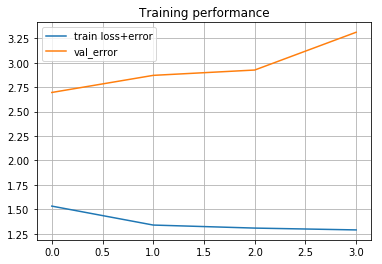

In [0]:
# Show simple version of performance                           
score2 = model.evaluate(X_test ,label_test,verbose=1)       
print('Test loss:',score2[0])
print('Test accuracy:',score2[1])                          
# Show loss curves                                          
plt.figure()
plt.grid()                                               # 0.46658333333333335  
                                                            
plt.title('Training performance')                          
plt.plot(history2.epoch, history2.history['loss'], label='train loss+error')  
plt.plot(history2.epoch, history2.history['val_loss'], label='val_error')   
plt.legend()

#CNN Architecture

In [0]:
model2= models.Sequential()

model2.add(Reshape((1,2,128), input_shape=(2,128)))
#model2.add(layers.ZeroPadding2D((0, 0)))
model2.add(Conv2D(64,(1, 3),padding='same',activation='relu'))   #,input_shape=(2,128)))
model2.add(Dropout(0.1))
#model2.add(layers.ZeroPadding2D((0, 0)))
model2.add(Conv2D(16, kernel_size=(2,3),padding='same', activation='relu'))
model2.add(Flatten())
model2.add(Dropout(0.1))
model2.add(Dense(128, activation='relu'))

model2.add(Dropout(0.1))
model2.add(Dense(10, activation='softmax'))#optimizer=optimizers.SGD(lr=0.01)
model2.add(Reshape([10]))
model2.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_5 (Reshape)          (None, 1, 2, 128)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 1, 2, 64)          24640     
_________________________________________________________________
dropout_11 (Dropout)         (None, 1, 2, 64)          0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 1, 2, 16)          6160      
_________________________________________________________________
flatten_4 (Flatten)          (None, 32)                0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 128)               4224      
__________

#Train the Model

In [0]:
from keras.callbacks import EarlyStopping

early_stopping_monitor = EarlyStopping(patience=5)
#train model               validation_data=(X_test,label_test)
#history=model2.fit(X_train,label_train, batch_size = 100,validation_split=0.05, epochs=100, callbacks=[early_stopping_monitor])
history = model2.fit(X_test ,label_test,validation_split=0.02 ,batch_size=50,epochs=100,verbose=1,callbacks=[early_stopping_monitor])
#predict
test_y_predictions = model2.predict(X_test)


Train on 588000 samples, validate on 12000 samples
Epoch 1/100
588000/588000 [==============================] - 51s 87us/step - loss: 1.5240 - acc: 0.3720 - val_loss: 1.4686 - val_acc: 0.3972
Epoch 2/100
588000/588000 [==============================] - 51s 87us/step - loss: 1.4811 - acc: 0.3850 - val_loss: 1.3953 - val_acc: 0.4237
Epoch 3/100
588000/588000 [==============================] - 51s 87us/step - loss: 1.4340 - acc: 0.3980 - val_loss: 1.3620 - val_acc: 0.4372
Epoch 4/100
588000/588000 [==============================] - 51s 87us/step - loss: 1.4173 - acc: 0.4027 - val_loss: 1.3715 - val_acc: 0.4124
Epoch 5/100
588000/588000 [==============================] - 50s 85us/step - loss: 1.4078 - acc: 0.4061 - val_loss: 1.3685 - val_acc: 0.4152
Epoch 6/100
588000/588000 [==============================] - 50s 86us/step - loss: 1.4002 - acc: 0.4085 - val_loss: 1.3764 - val_acc: 0.4187
Epoch 7/100
588000/588000 [==============================] - 50s 85us/step - loss: 1.3959 - acc: 0.4091

 #HyperTunning
 
 #0.41484333333333334
 #0.3772583333333333           zero padding
 ##0.4011266666666667        withoout zero padding 
 #0.44224                                    batch size32 
 #0.4585883333333333           batch size 2000
 #0.45925666666666665         with no shuffling
 #0.461815                                   30 epochs
 #0.4671383333333                   without early stop mafar2tsh kteer
 #0.4698616666666667            50 epochs
 #0.470635                                  100 epochs
 #0.4695                                       Batch1000
 #0.4895683333333333            bel test
 #0.4635533333333333            split=0.2
 #0.47201                                     split=0.07
 #0.472385                                   split=0.1
 #0.4666783333333333            split=0.02
 #0.474495                                   split=0.09
 #0.47951333333333335          split=0.05
 
 ##0.3419216666666667         with no shuffling tany
 #0.398765                                  batch 600
 #0.352515                                  batch 1000
 #0.42087833333333335         batch 100
 #0.429435                                   batch 50
 #0.4313633333333333             split 0.2
 #0.4706416666666667.            split 0.02
 #0.4700566666666667
 #0.45090833333333336           dr=0.04
 
 

#Evaluate and Plot Model Performance

600000/600000 [==============================] - 23s 39us/step
Test accuracy: 0.43611333333333335
Test loss: 1.3466326371383668


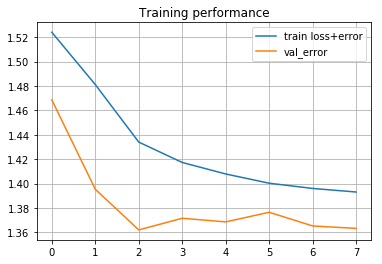

In [0]:
# Show simple version of performance                     
score = model2.evaluate(X_test ,label_test,verbose=1)   
print('Test accuracy:',score[1])                         
print('Test loss:',score[0])                             
# Show loss curves 
plt.figure()  #0.3419216666666667
plt.grid()
plt.title('Training performance')
plt.plot(history.epoch, history.history['loss'], label='train loss+error')
plt.plot(history.epoch, history.history['val_loss'], label='val_error')
plt.legend()                             

#Function To plot confusion_matrix 

In [0]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, labels=[]):
    #plt.figure(figsize = (10,7))
    plt.grid()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.grid()
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.grid() 
    

#Show confusion matrices and find the most confusing classes for CNN

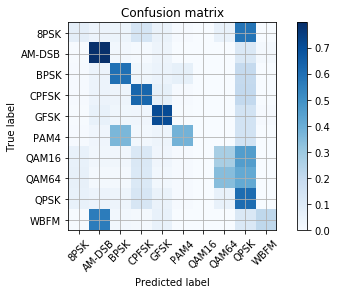

In [0]:
# Plot confusion matrix
test_Y_hat = model2.predict(X_test, batch_size=1024)
conf = np.zeros([10,10])
confnorm = np.zeros([10,10])
for i in range(0,X_test.shape[0]):
    j = list(label_test[i,:]).index(1)
    k = int(np.argmax(test_Y_hat[i,:]))
    conf[j,k] = conf[j,k] + 1
for i in range(0,10):
    confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
plot_confusion_matrix(confnorm, labels=mods)

Overall Accuracy:  0.1046690267851179
Overall Accuracy:  0.1072430843244688
Overall Accuracy:  0.11683940413903422
Overall Accuracy:  0.13079730770518702
Overall Accuracy:  0.16046992857619652
Overall Accuracy:  0.22222592358173157
Overall Accuracy:  0.28802309760063716
Overall Accuracy:  0.3616594849183285
Overall Accuracy:  0.4473578996468315
Overall Accuracy:  0.5302157309393005
Overall Accuracy:  0.5936818074999161
Overall Accuracy:  0.6231691078561917
Overall Accuracy:  0.6298759602274617
Overall Accuracy:  0.6336371168185584
Overall Accuracy:  0.6282404487668869
Overall Accuracy:  0.6273694712337878
Overall Accuracy:  0.6282537780440717
Overall Accuracy:  0.6294907944932825
Overall Accuracy:  0.6292490909697435


/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Overall Accuracy:  0.6311653569637184
Average OverAll Accuracy for CNN:
0.4361816910545226


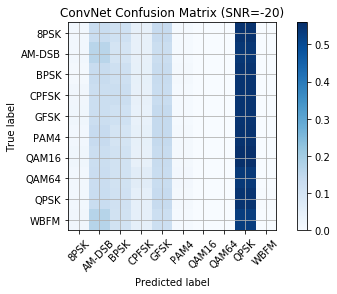

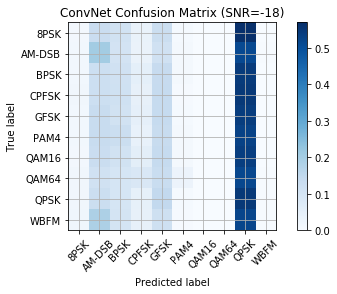

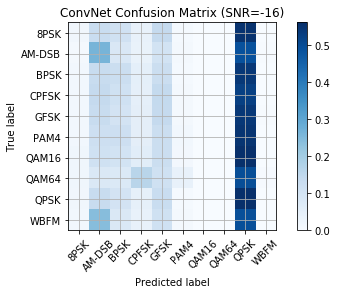

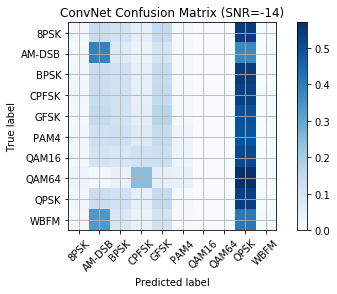

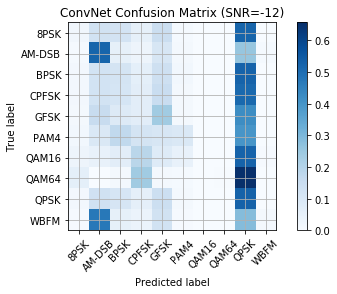

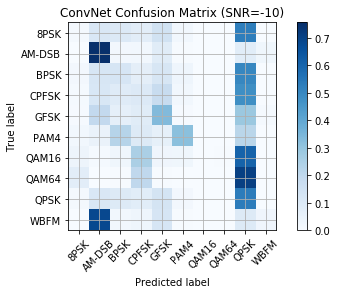

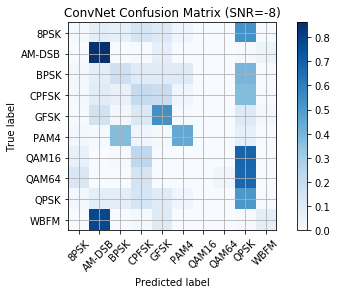

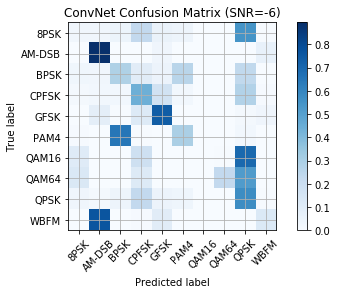

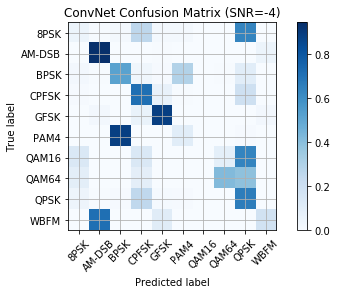

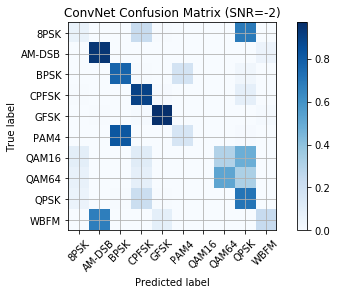

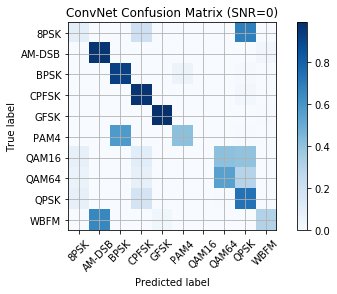

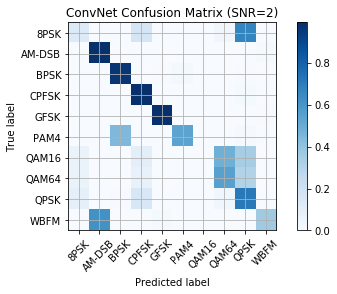

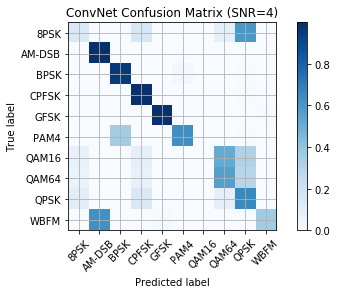

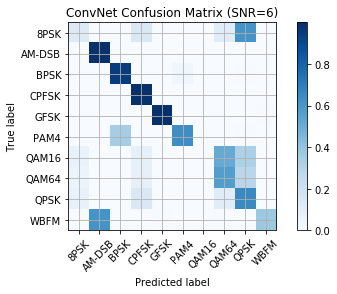

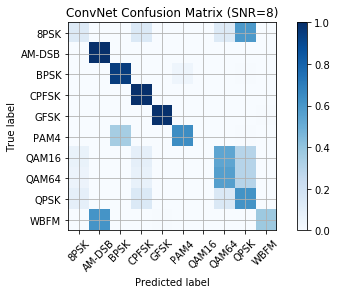

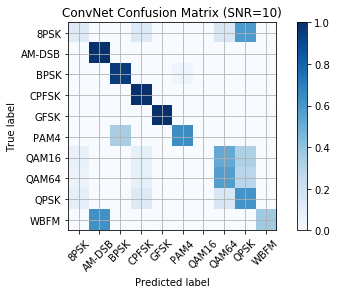

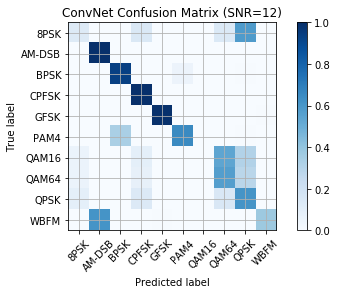

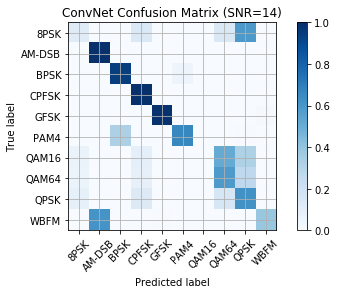

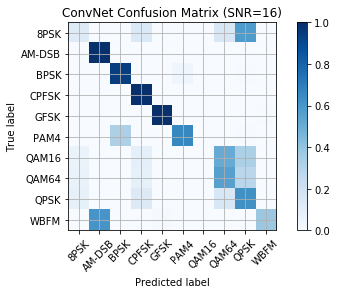

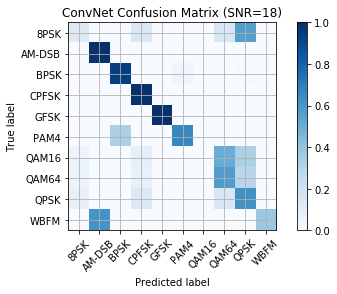

<Figure size 432x288 with 0 Axes>

In [0]:
# Plot confusion matrix
acc = []
accu_sum1=0
for snr in snrs:
# extract classes @ SNR
    test_SNRs = list(map(lambda x: label[x][1],test_idx))
    #print(test_SNRs)
    test_X_i = X_test[np.where(np.array(test_SNRs)==snr)]
    test_Y_i = label_test[np.where(np.array(test_SNRs)==snr)]    

    # estimate classes
    test_Y_i_hat = model2.predict(test_X_i)
    
    #print(test_SNRs)
    conf = np.zeros([10,10])
    confnorm = np.zeros([10,10])
    for i in range(0,test_X_i.shape[0]):
        j = list(test_Y_i[i,:]).index(1)
        k = int(np.argmax(test_Y_i_hat[i,:]))
        conf[j,k] = conf[j,k] + 1
        #print(conf[j,k])
    for i in range(0,10):
        confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
    plt.grid()    
    #plt.figure()
    plot_confusion_matrix(confnorm, labels=mods, title="ConvNet Confusion Matrix (SNR=%d)"%(snr))
    plt.grid()    
    plt.figure()
    cor = np.sum(np.diag(conf))
    ncor = np.sum(conf) - cor
    #print(conf)
    accu_sum1=accu_sum1+(cor / (cor+ncor))
    acc.append(cor / (cor+ncor))
    print("Overall Accuracy: " , cor / (cor+ncor))
averageAcc1=accu_sum1/20
print("Average OverAll Accuracy for CNN:")               
print(averageAcc1)
   

#Show confusion matrices and find the most confusing classes for ANN

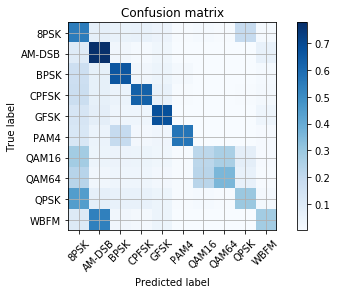

In [0]:
# Plot confusion matrix
test_Y_hat = model.predict(X_test, batch_size=1024)
conf = np.zeros([10,10])
confnorm = np.zeros([10,10])
for i in range(0,X_test.shape[0]):
    j = list(label_test[i,:]).index(1)
    k = int(np.argmax(test_Y_hat[i,:]))
    conf[j,k] = conf[j,k] + 1
for i in range(0,10):
    confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
plot_confusion_matrix(confnorm, labels=mods)

Overall Accuracy:  0.10493621000601162
Overall Accuracy:  0.10978217292529734
Overall Accuracy:  0.11443996400839804
Overall Accuracy:  0.13066336268961593
Overall Accuracy:  0.15903477738468727
Overall Accuracy:  0.21123288583896865
Overall Accuracy:  0.2933992632661866
Overall Accuracy:  0.43334335437752614
Overall Accuracy:  0.5658359432264943
Overall Accuracy:  0.6514471392201527
Overall Accuracy:  0.6987947762446705
Overall Accuracy:  0.7189081225033289
Overall Accuracy:  0.7245186392205114
Overall Accuracy:  0.731930405965203
Overall Accuracy:  0.7352540910147044
Overall Accuracy:  0.7343531759228467
Overall Accuracy:  0.7275813860595167
Overall Accuracy:  0.7327583347155415
Overall Accuracy:  0.7345298061847416


/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Overall Accuracy:  0.7325196455442233
Average OverAll Accuracy for ANN:
0.5022631728159315


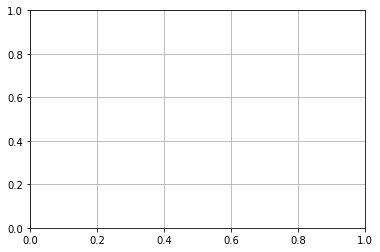

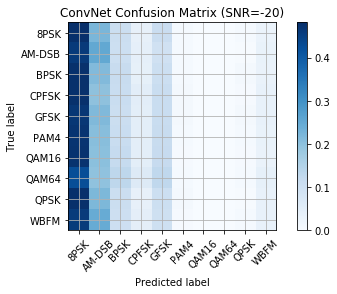

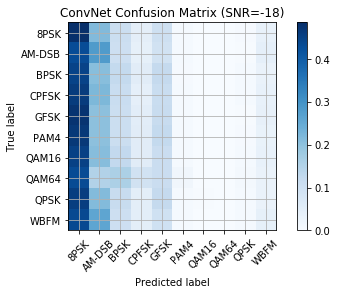

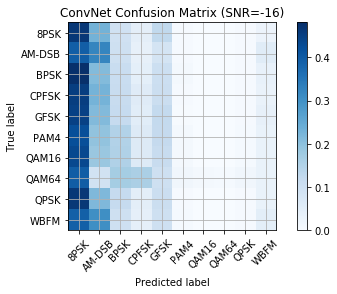

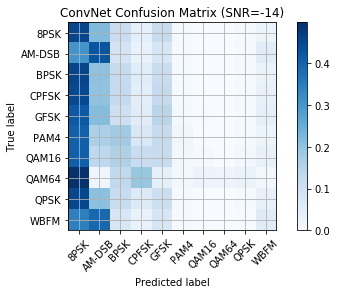

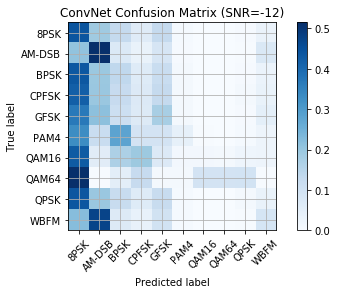

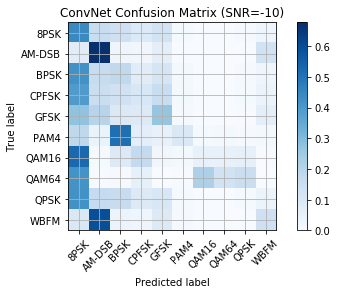

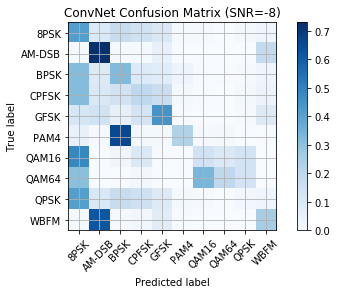

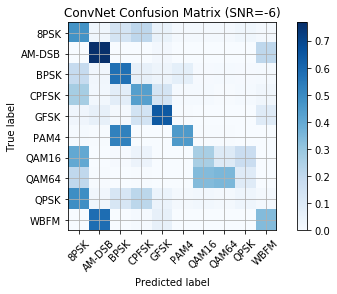

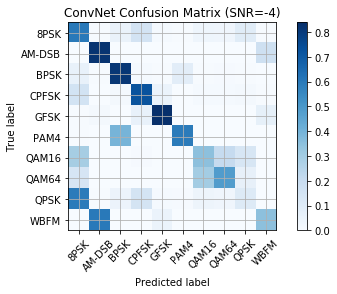

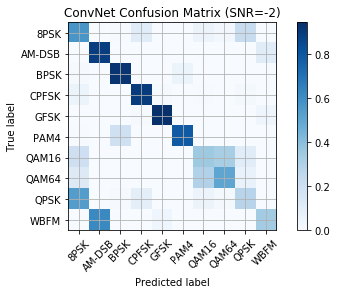

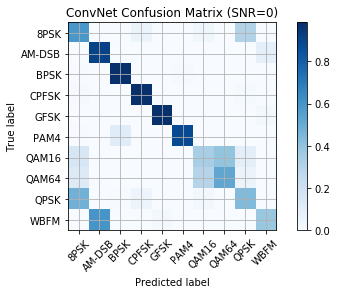

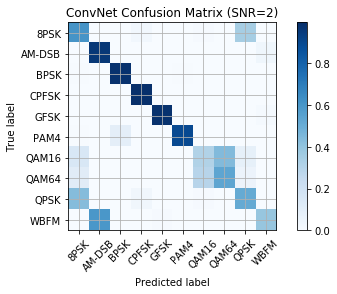

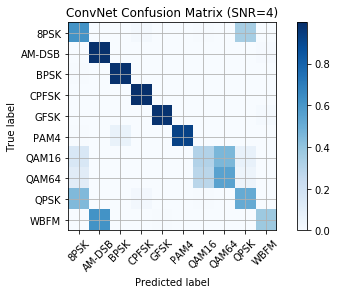

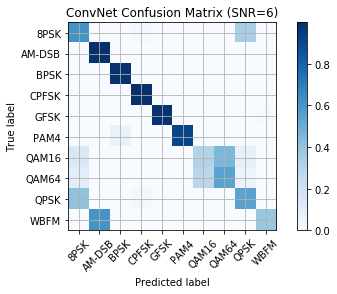

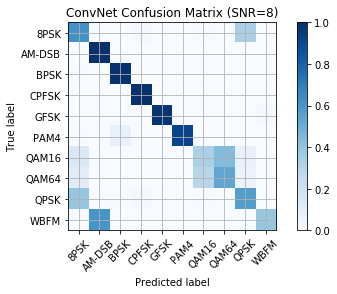

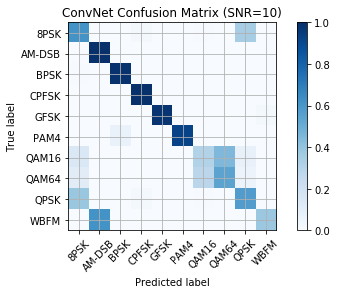

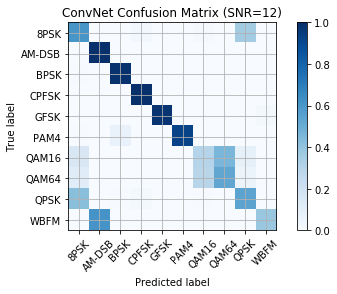

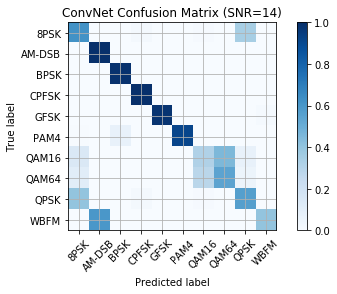

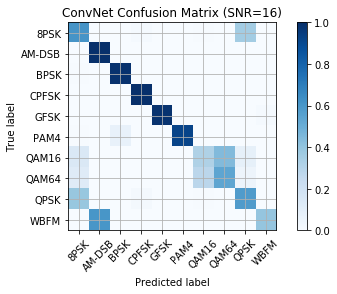

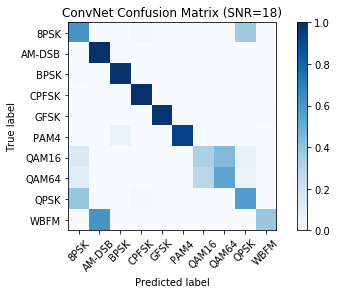

In [0]:
# Plot confusion matrix
acc1 =[]
accu_sum2=0
for snr in snrs:
# extract classes @ SNR
    test_SNRs = list(map(lambda x: label[x][1],test_idx))
    #print(test_SNRs)
    test_X_i = X_test[np.where(np.array(test_SNRs)==snr)]
    test_Y_i = label_test[np.where(np.array(test_SNRs)==snr)]    

    # estimate classes
    test_Y_i_hat = model.predict(test_X_i)
    
    #print(test_SNRs)
    conf = np.zeros([10,10])
    confnorm = np.zeros([10,10])
    for i in range(0,test_X_i.shape[0]):
        j = list(test_Y_i[i,:]).index(1)
        k = int(np.argmax(test_Y_i_hat[i,:]))
        conf[j,k] = conf[j,k] + 1
        #print(conf[j,k])
    for i in range(0,10):
        confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
    plt.grid()    
    #plt.grid()
    plt.figure()
    plot_confusion_matrix(confnorm, labels=mods, title="ConvNet Confusion Matrix (SNR=%d)"%(snr))
    
    plt.grid()
    cor = np.sum(np.diag(conf))
    ncor = np.sum(conf) - cor
    acc1.append(cor / (cor+ncor))
    accu_sum2=accu_sum2+(cor / (cor+ncor))
    #print(conf)
    print("Overall Accuracy: " , cor / (cor+ncor))
averageAcc2=accu_sum2/20
print("Average OverAll Accuracy for ANN:")   
print(averageAcc2)

Text(0.5, 1.0, ' Classification Accuracy on RadioML 2016.10 Alpha')

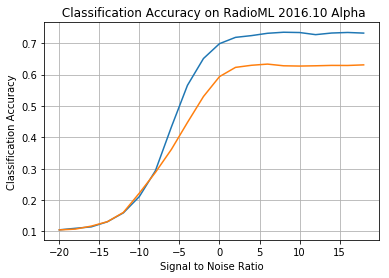

In [0]:
# Plot accuracy curve
#acc_snr =  np.array(map(lambda x: acc1[x],snrs))
#print(acc_snr.shape)
plt.plot(snrs,acc1,label="Fully Connected")
plt.plot(snrs,acc,label="CNN")
plt.grid()
plt.xlabel("Signal to Noise Ratio")
plt.ylabel("Classification Accuracy")
plt.title(" Classification Accuracy on RadioML 2016.10 Alpha")
plt.legend()

#Creating feature Spaces

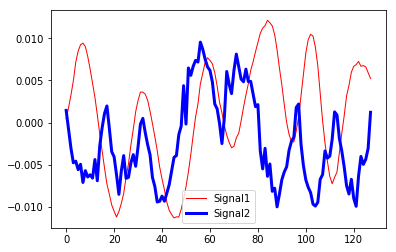

In [0]:
mysignals = [{'name': 'Signal1', 'x': np.arange(0,128,1),
             'y': X_train[0][0], 'color':'r', 'linewidth':1},
            {'name': 'Signal2', 'x': np.arange(0,128,1),
             'y': X_train[1][0], 'color':'b', 'linewidth':3}]

fig, ax = plt.subplots()
for signal in mysignals:
    ax.plot(signal['x'], signal['y'], 
            color=signal['color'], 
            linewidth=signal['linewidth'],
            label=signal['name'])

# Enable legend
ax.legend()
plt.show()

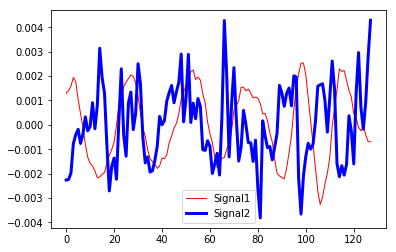

In [0]:
d1 = np.gradient(X_train[0][0])
d2 = np.gradient(X_train[1][0])
mysignals = [{'name': 'Signal1', 'x': np.arange(0,128,1),
             'y': d1, 'color':'r', 'linewidth':1},
            {'name': 'Signal2', 'x': np.arange(0,128,1),
             'y': d2, 'color':'b', 'linewidth':3}]

fig, ax = plt.subplots()
for signal in mysignals:
    ax.plot(signal['x'], signal['y'], 
            color=signal['color'], 
            linewidth=signal['linewidth'],
            label=signal['name'])

# Enable legend
ax.legend()
plt.show()

In [0]:
#Returns ndarrays corresponding to the derivatives of input array with respect to each dimension
d_train = np.gradient(X_train, axis=0)          
d_test = np.gradient(X_test, axis=0)
print(np.array(d_train).shape)

(600000, 2, 128)


In [0]:
#First derivative 
#The first order difference is given by out[n] = a[n+1] - a[n] along the given axis
diff_train = np.diff(X_train)
diff_test = np.diff(X_test)
print(diff_train.shape)

(600000, 2, 127)


In [0]:
from scipy import integrate
#Integration
#The INTEGRAL command is used to calculate the definite integral of a function. 
#The CUMULATIVE INTEGRAL command only applies to the case of a discrete set of points.
int_train = integrate.cumtrapz(X_train, initial=0)
int_test = integrate.cumtrapz(X_test, initial=0)
print(int_train.shape)

(600000, 2, 128)


In [0]:
#Combinations of original data, diff and int
#comb_train = np.vstack((X_train, d_train, int_train))
#print(comb_train.shape)
#comb_test = np.vstack((X_test, d_test, int_test))
#print(comb_test.shape)

(1800000, 2, 128)


#ANN for Differentiation features 

In [0]:
from keras.callbacks import EarlyStopping
#set early stopping monitor so the model stops training when it won't improve anymore  on a validation set of size 5% of the data.
early_stopping_monitor = EarlyStopping(patience=3) #validation_data=(X_train,label_train)
#train model
history2=model.fit(d_test,label_train, validation_split=0.05,shuffle=True ,epochs=100, callbacks=[early_stopping_monitor], batch_size = 100)
#predict
test_y_predictions = model.predict(d_test)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Train on 570000 samples, validate on 30000 samples
Epoch 1/100
570000/570000 [==============================] - 66s 116us/step - loss: 2.3027 - acc: 0.0999 - val_loss: 2.3026 - val_acc: 0.1022
Epoch 2/100
570000/570000 [==============================] - 65s 114us/step - loss: 2.3027 - acc: 0.1000 - val_loss: 2.3026 - val_acc: 0.0988
Epoch 3/100
570000/570000 [==============================] - 64s 112us/step - loss: 2.3027 - acc: 0.0997 - val_loss: 2.3027 - val_acc: 0.0998
Epoch 4/100
570000/570000 [==============================] - 63s 111us/step - loss: 2.3027 - acc: 0.0996 - val_loss: 2.3026 - val_acc: 0.1022
Epoch 5/100
570000/570000 [==============================] - 64s 113us/step - loss: 2.3027 - acc: 0.0993 - val_loss: 2.3027 - val_acc: 0.0983
Epoch 6/100
570000/570000 [==============================] - 64s 112us/step 

600000/600000 [==============================] - 31s 52us/step
Test loss: 2.3026583561197915
Test accuracy: 0.10008666666666667


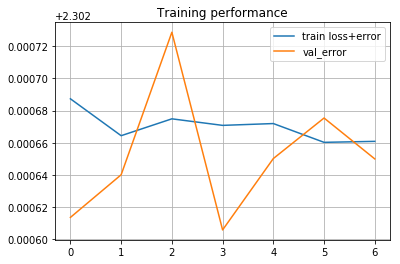

In [0]:
# Show simple version of performance                           
score2 = model.evaluate(d_test,label_train,verbose=1)       
print('Test loss:',score2[0])
print('Test accuracy:',score2[1])                          
# Show loss curves                                          
plt.figure()
plt.grid()                                               # 0.46658333333333335  
                                                            
plt.title('Training performance')                          
plt.plot(history2.epoch, history2.history['loss'], label='train loss+error')  
plt.plot(history2.epoch, history2.history['val_loss'], label='val_error')   
plt.legend()

#CNN for Differentiation features

In [0]:
from keras.callbacks import EarlyStopping

early_stopping_monitor = EarlyStopping(patience=5)
#train model               validation_data=(X_test,label_test)
#history=model2.fit(X_train,label_train, batch_size = 100,validation_split=0.05, epochs=100, callbacks=[early_stopping_monitor])
history = model2.fit(d_test,label_train,validation_split=0.02 ,batch_size=50,epochs=100,verbose=1,callbacks=[early_stopping_monitor])
#predict
test_y_predictions = model2.predict(d_test)

Train on 588000 samples, validate on 12000 samples
Epoch 1/100
588000/588000 [==============================] - 108s 183us/step - loss: 2.3027 - acc: 0.1003 - val_loss: 2.3026 - val_acc: 0.1017
Epoch 2/100
588000/588000 [==============================] - 129s 219us/step - loss: 2.3027 - acc: 0.1004 - val_loss: 2.3026 - val_acc: 0.1015
Epoch 3/100
588000/588000 [==============================] - 141s 240us/step - loss: 2.3027 - acc: 0.1001 - val_loss: 2.3030 - val_acc: 0.0980
Epoch 4/100
588000/588000 [==============================] - 141s 240us/step - loss: 2.3027 - acc: 0.0997 - val_loss: 2.3028 - val_acc: 0.1017
Epoch 5/100
588000/588000 [==============================] - 138s 235us/step - loss: 2.3027 - acc: 0.1001 - val_loss: 2.3027 - val_acc: 0.0983
Epoch 6/100
588000/588000 [==============================] - 131s 223us/step - loss: 2.3027 - acc: 0.1000 - val_loss: 2.3028 - val_acc: 0.0977


600000/600000 [==============================] - 22s 36us/step
Test accuracy: 0.09988833333333333
Test loss: 2.3027212101999917


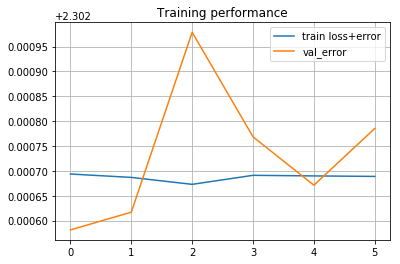

In [0]:
# Show simple version of performance                     
score = model2.evaluate(d_test,label_test,verbose=1)   
print('Test accuracy:',score[1])                         
print('Test loss:',score[0])                             
# Show loss curves 
plt.figure()  #0.3419216666666667
plt.grid()
plt.title('Training performance')
plt.plot(history.epoch, history.history['loss'], label='train loss+error')
plt.plot(history.epoch, history.history['val_loss'], label='val_error')
plt.legend()                             

#ANN for Integrated features

In [0]:
from keras.callbacks import EarlyStopping
#set early stopping monitor so the model stops training when it won't improve anymore  on a validation set of size 5% of the data.
early_stopping_monitor = EarlyStopping(patience=3) #validation_data=(X_train,label_train)
#train model
history2=model.fit(int_test,label_train, validation_split=0.05,shuffle=True ,epochs=100, callbacks=[early_stopping_monitor], batch_size = 100)
#predict
test_y_predictions = model.predict(int_test)

In [0]:
# Show simple version of performance                           
score2 = model.evaluate(int_test,label_train,verbose=1)       
print('Test loss:',score2[0])
print('Test accuracy:',score2[1])                          
# Show loss curves                                          
plt.figure()
plt.grid()                                               # 0.46658333333333335  
                                                            
plt.title('Training performance')                          
plt.plot(history2.epoch, history2.history['loss'], label='train loss+error')  
plt.plot(history2.epoch, history2.history['val_loss'], label='val_error')   
plt.legend()

#CNN for Integrated features

In [0]:
from keras.callbacks import EarlyStopping

early_stopping_monitor = EarlyStopping(patience=5)
#train model               validation_data=(X_test,label_test)
#history=model2.fit(X_train,label_train, batch_size = 100,validation_split=0.05, epochs=100, callbacks=[early_stopping_monitor])
history = model2.fit(int_test,label_train,validation_split=0.02 ,batch_size=50,epochs=100,verbose=1,callbacks=[early_stopping_monitor])
#predict
test_y_predictions = model2.predict(d_train)

In [0]:
# Show simple version of performance                     
score = model2.evaluate(int_test,label_test,verbose=1)   
print('Test accuracy:',score[1])                         
print('Test loss:',score[0])                             
# Show loss curves 
plt.figure()  #0.3419216666666667
plt.grid()
plt.title('Training performance')
plt.plot(history.epoch, history.history['loss'], label='train loss+error')
plt.plot(history.epoch, history.history['val_loss'], label='val_error')
plt.legend()                             